## INFERENCE MODEL
Setup inference model

In [1]:
import os, sys
sys.path.append(os.path.split(sys.path[0])[0])

#Dependencies
import h5py
import math
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
import sbi.analysis as analysis
from sbi.utils.get_nn_models import posterior_nn  # For SNLE: likelihood_nn(). For SNRE: classifier_nn()
from scipy import signal, stats as spstats
import scipy.io
import torch
import torch.nn as nn
import torch.nn.functional as F

#Project Imports
import config.params as params
import config.paths as paths
from stylized_module.base.passive_model_soma_injection import run_pm_simulation
from stylized_module.base.active_model_synapse_input import run_am_simulation
from stylized_module.models.SummaryStats2D import Stats, cat_output
from utils.metrics.corrcoef import corrcoef, max_corrcoef
from utils.plotting.plot_results import plot_LFP_traces,plot_LFP_heatmap
from utils.spike_window import first_pk_tr, get_spike_window
from utils.transform.distribution_transformation import norm2unif, range2logn, norm2logn, logds_norm2unif, logds_norm2logn

Helper Functions

In [2]:
rng = np.random.default_rng(123412)

def passive_model(param,whole_trace=False):
    #Replace theta with random number
    theta = [rng.uniform(low=params.IM_THETA_BOUNDS[0], high=params.IM_THETA_BOUNDS[1])]
    sim.set_loc_param(torch.cat((torch.zeros(1),param[:2], torch.tensor(theta), param[2:4])))
    scalVal = 1 #10 ** param[5]
    sim.set_scale(scalVal)
    sim.set_geo_param(param[4:])
    sim.create_cells()
    sim.run()
    lfp = sim.get_lfp().T
    filtered_lfp = signal.lfilter(filt_b,filt_a,lfp,axis=0) # filter along row of the lfp 2d-array, if each row is a channel
    if not whole_trace:
        start,end = get_spike_window(filtered_lfp,win_size=params.PM_WINDOW_SIZE,align_at=fst_idx)
        filtered_lfp = filtered_lfp[start:end,:]
    return filtered_lfp

def active_model(param,whole_trace=False):
#     biophys = [param[0],-1,-1,param[1],-1,param[2],-1]
#     sim.set_biophys(biophys)
    
    #Replace alpha with random number
    alpha = rng.uniform(low=params.IM_ALPHA_BOUNDS[0], high=params.IM_ALPHA_BOUNDS[1])
    d = norm2unif(param[1], params.IM_PARAMETER_BOUNDS[1][0], params.IM_PARAMETER_BOUNDS[1][1])
    theta = norm2unif(param[2], params.IM_PARAMETER_BOUNDS[2][0], params.IM_PARAMETER_BOUNDS[2][1])
    x = d * np.sin(theta)
    z = d * np.cos(theta)
    
    numpy_list = np.array([
        x, #x
        norm2unif(param[0], params.IM_PARAMETER_BOUNDS[0][0], params.IM_PARAMETER_BOUNDS[0][1]), #y
        z, #z
        alpha, #alpha
        norm2unif(param[3], params.IM_PARAMETER_BOUNDS[3][0], params.IM_PARAMETER_BOUNDS[3][1]), #h
        norm2unif(param[4], params.IM_PARAMETER_BOUNDS[4][0], params.IM_PARAMETER_BOUNDS[4][1]) #phi
    ])
    
    sim.set_loc_param(torch.from_numpy(numpy_list))

    m1,s1=range2logn(params.IM_PARAMETER_BOUNDS[5][0], params.IM_PARAMETER_BOUNDS[5][1])
    m2,s2=range2logn(params.IM_PARAMETER_BOUNDS[6][0], params.IM_PARAMETER_BOUNDS[6][1])
    m3,s3=range2logn(params.IM_PARAMETER_BOUNDS[7][0], params.IM_PARAMETER_BOUNDS[7][1])
    m4,s4=range2logn(params.IM_PARAMETER_BOUNDS[8][0], params.IM_PARAMETER_BOUNDS[8][1])
    m5,s5=range2logn(params.IM_PARAMETER_BOUNDS[9][0], params.IM_PARAMETER_BOUNDS[9][1])
    m6,s6=range2logn(params.IM_PARAMETER_BOUNDS[10][0], params.IM_PARAMETER_BOUNDS[10][1])

    numpy_list = np.array([
        norm2logn(param[5],m1,s1), #r_s
        norm2logn(param[6],m2,s2), #l_t
        norm2logn(param[7],m3,s3), #r_t
        norm2logn(param[8],m4,s4), #r_d
        norm2logn(param[9],m5,s5), #r_tu, shouldn't be inferred?
        norm2logn(param[10],m6,s6) #l_d
    ])

    sim.set_geo_param(torch.from_numpy(numpy_list))

    scalVal = 1 #10 ** param[5]
    sim.set_scale(scalVal)
    
    sim.set_gmax(params.GT_GMAX)
#     scalVal = 10 ** param[4]
    sim.set_scale(scalVal)
    sim.create_cells()
    sim.run()
    lfp = sim.get_lfp().T
    filtered_lfp = signal.lfilter(filt_b,filt_a,lfp,axis=0) # filter along row of the lfp 2d-array, if each row is a channel
    if not whole_trace:
        start,end = get_spike_window(filtered_lfp,win_size=params.AM_WINDOW_SIZE,align_at=fst_idx)
        filtered_lfp = filtered_lfp[start:end,:]
    return filtered_lfp

# def Stats(lfp):
#     """
#     Calculates summary statistics
#     results = model(params)
#     """
#     lfp = np.asarray(lfp)
    
#     avg = np.mean(lfp,axis=0) # average voltage of each channel
# #     stdDev = np.std(lfp,axis=0) # stDev of the voltage of each channel
#     tT = np.argmin(lfp,axis=0)
#     tP = np.argmax(lfp,axis=0)
#     Troughs = np.take_along_axis(lfp,np.expand_dims(tT,axis=0),axis=0)
#     Peaks = np.take_along_axis(lfp,np.expand_dims(tP,axis=0),axis=0)
#     relT = tP-tT
#     stats_list = [avg,Troughs,Peaks,relT]
    
#     def statscalc(stats):
#         stats = stats.ravel()
#         mean = np.mean(stats)
#         std = np.std(stats)
#         m = np.argmin(stats)
#         min_pos = params.IM_Y_DISTANCE[m]
#         min_val = stats[m]
#         M = np.argmax(stats)
#         max_pos = params.IM_Y_DISTANCE[M] 
#         max_val = stats[M]
#         All = np.array([mean,std,min_pos,min_val,max_pos,max_val])
#         return All
    
#     allStats = np.concatenate([statscalc(x) for x in stats_list])
#     return allStats

# def cat_output(lfp):
#     output = np.concatenate((lfp.ravel(),Stats(lfp)))
#     return torch.from_numpy(output)

def simulation(sim_params):
    lfp = passive_model(sim_params) if params.ACTIVE_CELL is False else active_model(sim_params)
    return cat_output(lfp)

In [3]:
filt_b,filt_a = signal.butter(params.IM_BUTTERWORTH_ORDER,
                              params.IM_CRITICAL_FREQUENCY,
                              params.IM_BANDFILTER_TYPE,
                              fs=params.IM_FILTER_SAMPLING_RATE)

sim, window_size, x0_trace, t0 = run_pm_simulation() if params.ACTIVE_CELL is False else run_am_simulation()

fst_idx = first_pk_tr(x0_trace)

In [4]:
simulator, prior = prepare_for_sbi(simulation, params.IM_PRIOR_DISTRIBUTION)
x_o = cat_output(x0_trace)
print(x_o.shape)

torch.Size([72991])


In [5]:
# instantiate the neural density estimator
density_estimator_build_fun = posterior_nn(model=params.IM_POSTERIOR_MODEL_ESTIMATOR,
                                           embedding_net=params.IM_EMBEDDED_NETWORK,
                                           hidden_features=params.IM_POSTERIOR_MODEL_HIDDEN_LAYERS)

inference = SNPE(prior=prior,density_estimator=density_estimator_build_fun,show_progress_bars=True)

In [6]:
posteriors = []
proposal = prior

for i in range(params.IM_NUMBER_OF_ROUNDS):
    theta, x = simulate_for_sbi(simulator,proposal,num_simulations=params.IM_NUMBER_OF_SIMULATIONS)
     # In `SNLE` and `SNRE`, you should not pass the `proposal` to `.append_simulations()`
#     density_estimator = inference.append_simulations(np.squeeze(theta), np.squeeze(x), proposal=proposal).train()
    density_estimator = inference.append_simulations(np.squeeze(theta), x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator, sample_with="mcmc")
    
    with open(paths.POSTERIOR_SAVE + str(i) + "_post.pkl", "wb") as handle:
        pickle.dump(posterior, handle)
        
    with open(paths.POSTERIOR_SAVE + str(i) + "_de.pkl", "wb") as handle:
        pickle.dump(density_estimator, handle)
        
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)
    
inference._summary_writer = None
inference._build_neural_net = None
with open(paths.INFERENCER_SAVE + str(i) + ".pkl", "wb") as handle:
    pickle.dump(inference, handle)

# with open(paths.POSTERIOR_SAVE + "1_post.pkl", "rb") as handle:
#     posterior = pickle.load(handle)

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

Neural network successfully converged after 95 epochs.


Generating samples: 100%|██████████| 1000/1000 [8:24:24<00:00, 30.26s/it] 


Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
Neural network successfully converged after 82 epochs.


Generating samples: 100%|██████████| 1000/1000 [8:17:35<00:00, 29.86s/it] 


(array([  2.,   0.,   6.,  15.,  57.,  95., 221., 293., 247.,  64.]),
 array([-36.42436228, -34.55944375, -32.69452522, -30.8296067 ,
        -28.96468817, -27.09976964, -25.23485111, -23.36993258,
        -21.50501406, -19.64009553, -17.775177  ]),
 <BarContainer object of 10 artists>)

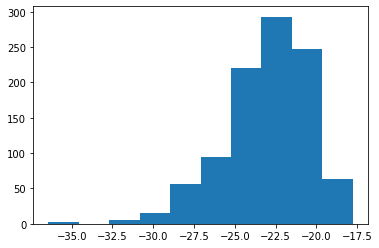

In [7]:
samples = posterior.sample((1000,), x=x_o, sample_with='mcmc') #, sample_with_mcmc=True

#posterior.leakage_correction(x_o, num_rejection_samples=1000)
log_probability = posterior.log_prob(samples,x=x_o, norm_posterior=False) #, norm_posterior=False
log_prob_t = log_probability
for i in range(5):
    log_prob_t += logds_norm2unif(samples[:,i], params.IM_PARAMETER_BOUNDS[i][0], params.IM_PARAMETER_BOUNDS[i][1])
for i in range(5,11):
    m,s=range2logn(params.IM_PARAMETER_BOUNDS[i][0], params.IM_PARAMETER_BOUNDS[i][1])
    log_prob_t += logds_norm2logn(samples[:,i], m, s)
plt.hist(log_prob_t.numpy())

In [8]:
sample_idx = np.argmax(log_prob_t)
samples_t = torch.clone(samples)
for i in range(5):
    samples_t[:,i] = torch.from_numpy(norm2unif(samples[:,i], params.IM_PARAMETER_BOUNDS[i][0], params.IM_PARAMETER_BOUNDS[i][1]))
for i in range(5,11):
    m,s=range2logn(params.IM_PARAMETER_BOUNDS[i][0], params.IM_PARAMETER_BOUNDS[i][1])
    samples_t[:,i] = norm2logn(samples[:,i], m, s)
predicted_post = samples[sample_idx]
predicted_post

tensor([ 0.2372, -0.1500,  0.0667,  0.9242,  2.1415,  1.5753, -0.1800, -0.4103,
        -0.0075,  0.1313,  0.0694])

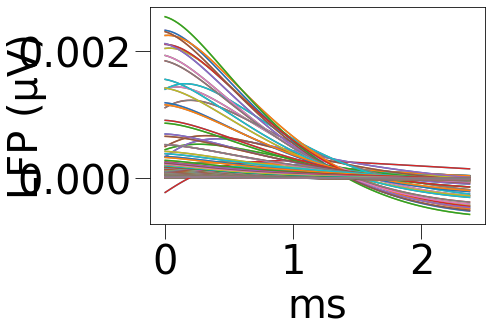

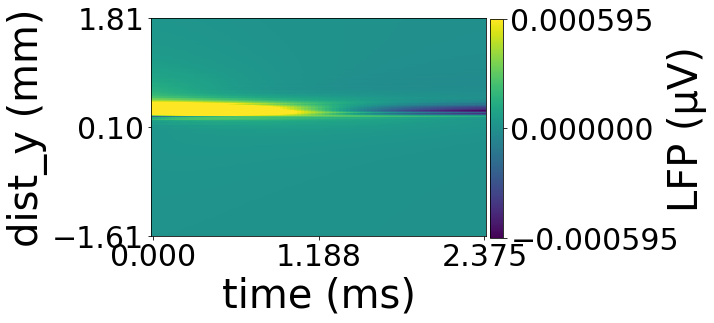

In [9]:
save_xo = params.IM_SAVE_X0
# save_xo = 'x_0_traces.pdf'
fig,ax = plot_LFP_traces(t0,x0_trace,savefig=params.IM_SAVE_X0)
# save_xo = 'x_0_HTmap.pdf'
elec_idx = slice(30,-10)
fig,ax = plot_LFP_heatmap(t0,params.IM_Y_DISTANCE[elec_idx],x0_trace[:,elec_idx],vlim='auto',savefig=params.IM_SAVE_X0)

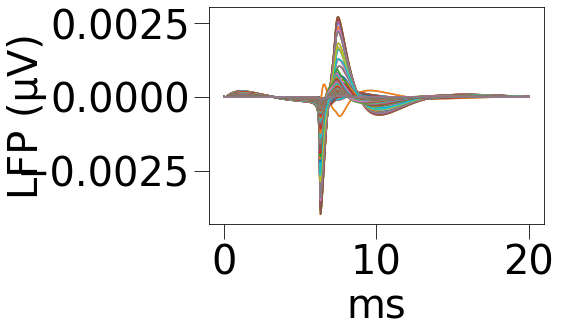

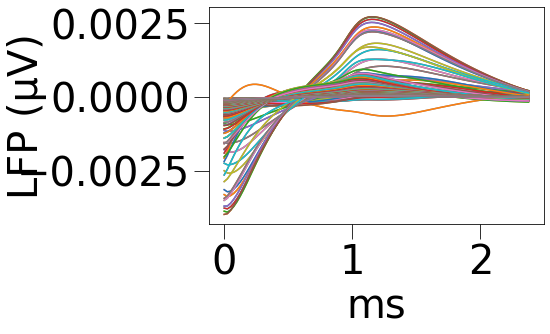

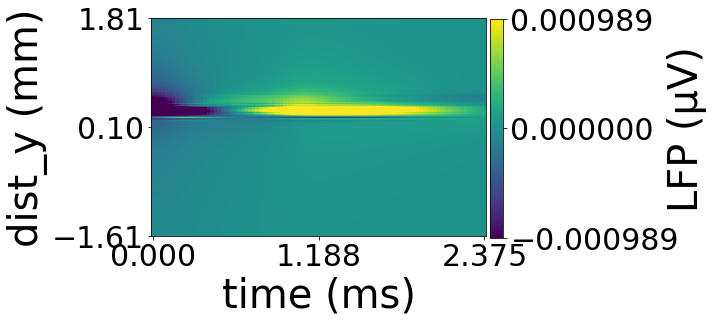

In [10]:
# predicted_lfp = passive_model(params.IM_RANDOM_SAMPLE,whole_trace=True)
predicted_lfp = passive_model(predicted_post,whole_trace=True) if params.ACTIVE_CELL is False else active_model(predicted_post, whole_trace=True)

fig,ax = plot_LFP_traces(sim.t(),predicted_lfp)
start,end = get_spike_window(predicted_lfp,win_size=params.PM_WINDOW_SIZE,align_at=fst_idx)
predicted_lfp_win = predicted_lfp[start:end,:]

savefig = paths.PASSIVE_INFERENCE_SAVE_TRACES if params.ACTIVE_CELL is False else paths.ACTIVE_INFERENCE_SAVE_TRACES
fig,ax = plot_LFP_traces(t0,
                         predicted_lfp_win,
                         savefig=savefig)

savefig = paths.PASSIVE_INFERENCE_SAVE_HEATMAPS if params.ACTIVE_CELL is False else paths.ACTIVE_INFERENCE_SAVE_HEATMAPS
fig,ax = plot_LFP_heatmap(t0,
                          params.IM_Y_DISTANCE[elec_idx],
                          predicted_lfp_win[:,elec_idx],
                          vlim='auto',
                          savefig=savefig)

In [11]:
max_corr, max_ind = max_corrcoef(x0_trace,predicted_lfp)
print(max_corr,max_ind)
max_corr, max_ind = max_corrcoef(x0_trace,predicted_lfp_win)
print(max_corr,max_ind)

0.9553565523314084 296
-0.41102558483581175 0


In [12]:
hf_file = paths.PASSIVE_INFERENCE_RESULTS_DATA if params.ACTIVE_CELL is False else paths.ACTIVE_INFERENCE_RESULTS_DATA
hf = h5py.File(hf_file, 'w')
hf.create_dataset('LFP',data=predicted_lfp)
hf.create_dataset('samples',data=samples.numpy())
hf.create_dataset('log_prob',data=log_probability.numpy())
hf.close()

mat_file = paths.PASSIVE_INFERENCE_RESULTS_MATLAB_DATA if params.ACTIVE_CELL is False else paths.ACTIVE_INFERENCE_RESULTS_MATLAB_DATA
scipy.io.savemat(mat_file,
                 {'LFP':predicted_lfp_win[:,elec_idx],'t':t0,'y_dist':params.IM_Y_DISTANCE[elec_idx]})

mat_file = paths.PASSIVE_INFERENCE_RESULTS_X0_MATLAB_DATA if params.ACTIVE_CELL is False else paths.ACTIVE_INFERENCE_RESULTS_X0_MATLAB_DATA
scipy.io.savemat(mat_file,
                 {'LFP':x0_trace[:,elec_idx],'t':t0,'y_dist':params.IM_Y_DISTANCE[elec_idx]})

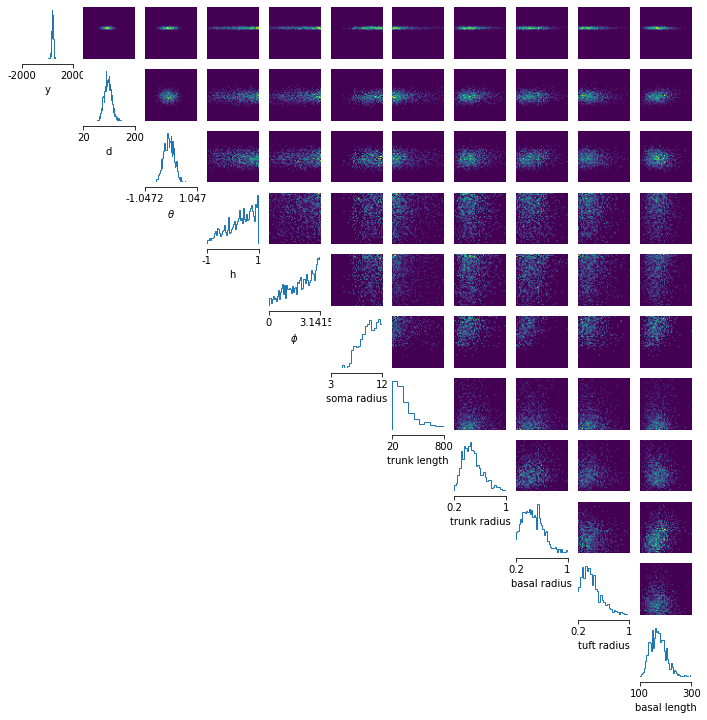

In [13]:
labels_params = IM_GRAPHING_LABELS = [r'y',r'd',r'$\theta$',r'h',r'$\phi$',r'soma radius',r'trunk length',r'trunk radius',r'basal radius',r'tuft radius',r'basal length']
fig, axes = analysis.pairplot(samples_t,
                           limits = params.IM_PARAMETER_BOUNDS,
                           ticks = params.IM_PARAMETER_BOUNDS,
                           figsize=(12,12),
                           #points=true_params,
                           points_offdiag={'markersize': 6},
                           labels = labels_params,
                           points_colors='r');

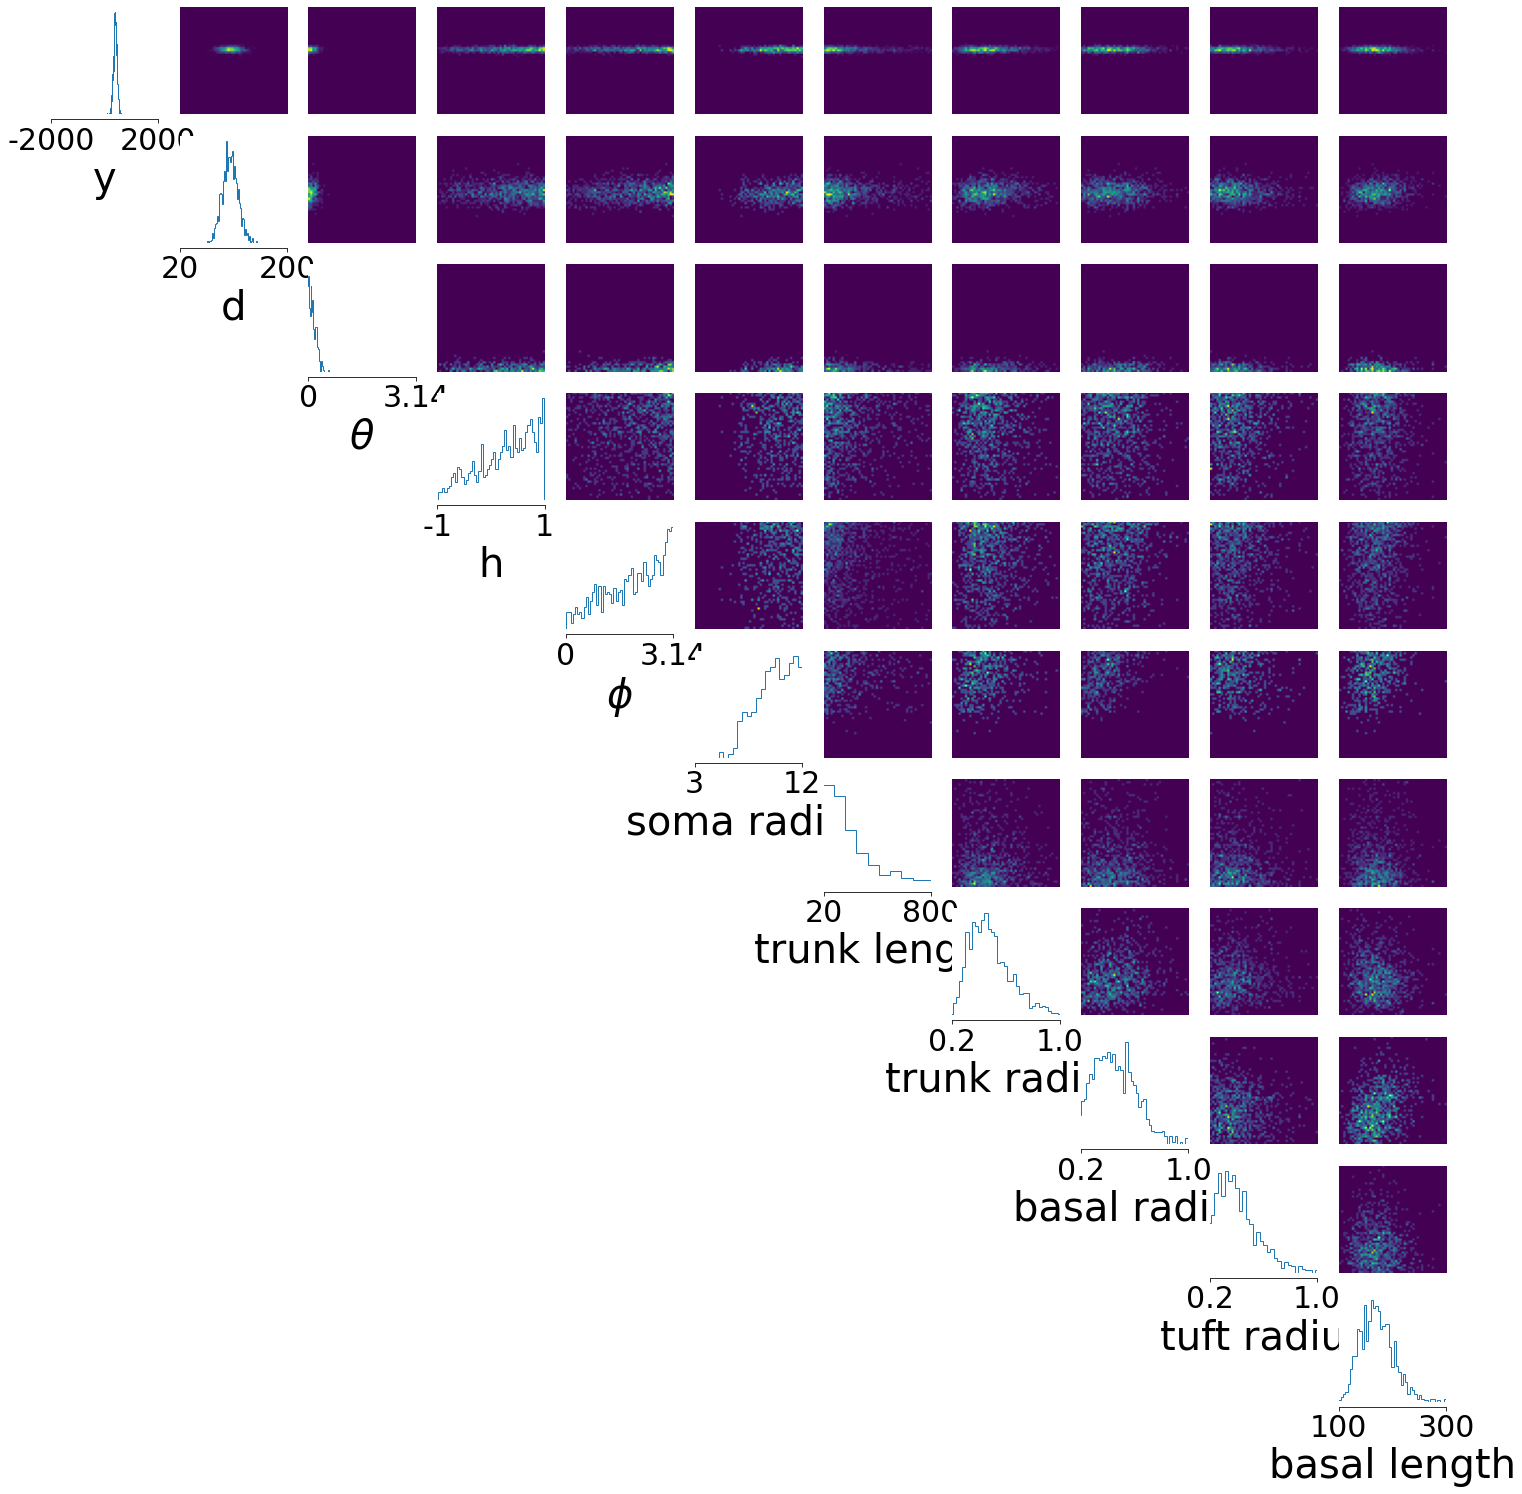

In [14]:
%matplotlib inline

# labels_params = params.IM_GRAPHING_LABELS
bounds_ticks = params.IM_PARAMETER_BOUNDS
bounds_ticks[2] = bounds_ticks[4] = [0,3.14]
fig, axes = analysis.pairplot(samples_t,
                           limits = params.IM_PARAMETER_BOUNDS,
                           ticks = params.IM_PARAMETER_BOUNDS,
                           figsize=(25,25),
                           #points=true_params,
                           points_offdiag={'markersize': 6},
                           labels = labels_params,
                           points_colors='r');

# axes[4][4].set_xlabel('\u03BB',fontsize = 40)
for i in range(len(params.IM_PARAMETER_BOUNDS)):
    axes[i][i].tick_params('x',labelsize=15)
    axes[i][i].xaxis.label.set_fontsize(40)

for i,b in enumerate(params.IM_PARAMETER_BOUNDS):
    axes[i][i].set_xticklabels([str(b[0]),str(b[1])],fontsize=30)

    
save_file = paths.PASSIVE_INFERENCE_SAVE_KDE if params.ACTIVE_CELL is False else paths.ACTIVE_INFERENCE_SAVE_KDE
plt.savefig(save_file,bbox_inches='tight',transparent=True)